In [1]:
%matplotlib inline
import sys
sys.path.append("../")
sys.path.append('/home/hao/Research/probtorch/')
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from plots import *
from kls import *
from NG_nats import *
from utils import *
from objectives import *
from torch.distributions.normal import Normal
from torch.distributions.one_hot_categorical import OneHotCategorical as cat
from torch.distributions.gamma import Gamma
import time
import probtorch
print('probtorch:', probtorch.__version__, 
      'torch:', torch.__version__, 
      'cuda:', torch.cuda.is_available())

probtorch: 0.0+5a2c637 torch: 1.0.0 cuda: True


In [2]:
N = 60
K = 3
D = 2

## Model Parameters
MCMC_SIZE = 10
SAMPLE_SIZE = 10
NUM_HIDDEN1 = 8
NUM_STATS = 1 + 2 * D
NUM_LATENTS =  D
## Training Parameters
SAMPLE_DIM = 0
BATCH_DIM = 1
BATCH_SIZE = 20
NUM_EPOCHS = 1500
LEARNING_RATE = 1e-4
CUDA = torch.cuda.is_available()
PATH = 'ag-sis-2k-learn-stat-init-z-resample'

gpu2 = torch.device('cuda:0')
data_path = "../gmm_dataset_conjugate2k"

In [3]:
Xs = torch.from_numpy(np.load(data_path + '/obs.npy')).float()
STATES = torch.from_numpy(np.load(data_path + '/states.npy')).float()
Pi = torch.from_numpy(np.load(data_path + '/init.npy')).float()
NUM_SEQS = Xs.shape[0]
NUM_BATCHES = int((Xs.shape[0] / BATCH_SIZE))

In [4]:
class Enc_eta(nn.Module):
    def __init__(self, num_obs=D,
                       num_hidden1=NUM_HIDDEN1,
                       num_stats=NUM_STATS,
                       num_latents=NUM_LATENTS):
        super(self.__class__, self).__init__()
        
        self.gamma = nn.Sequential(
            nn.Linear(K+D, K),
            nn.Softmax(-1))
        
        self.ob = nn.Sequential(
            nn.Linear(K+D, D))
        
        self.prior_mu = torch.zeros((K, D))
        self.prior_nu = torch.ones((K, D)) * 0.3
        self.prior_alpha = torch.ones((K, D)) * 4
        self.prior_beta = torch.ones((K, D)) * 4
        if CUDA:
            self.prior_mu = self.prior_mu.cuda().to(gpu2)
            self.prior_nu = self.prior_nu.cuda().to(gpu2)
            self.prior_alpha = self.prior_alpha.cuda().to(gpu2)
            self.prior_beta = self.prior_beta.cuda().to(gpu2)
        
    def forward(self, data):
        gammas = self.gamma(data) # S * B * N * K --> S * B * N * K
        xs = self.ob(data)  # S * B * N * D --> S * B * N * D
        q_alpha, q_beta, q_mu, q_nu = post_param(xs, gammas, 
                                                 self.prior_alpha, self.prior_beta, self.prior_mu, self.prior_nu, K, D)
   
        q = probtorch.Trace()
        precisions = Gamma(q_alpha, q_beta).sample()
        q.gamma(q_alpha,
                q_beta,
                value=precisions,
                name='precisions')
        
        p = probtorch.Trace()
        p.gamma(self.prior_alpha,
                self.prior_beta,
                value=q['precisions'],
                name='precisions')   
  
        means = Normal(q_mu, 1. / (q_nu * q['precisions'].value).sqrt()).sample()
        q.normal(q_mu, 
                 1. / (q_nu * q['precisions'].value).sqrt(), 
                 value=means, 
                 name='means')
        p.normal(self.prior_mu, 
                 1. / (self.prior_nu * q['precisions'].value).sqrt(), 
                 value=q['means'], 
                 name='means')    
        return q, p, q_nu

class Enc_z(nn.Module):
    def __init__(self, num_obs=3*D,
                       num_hidden=3*D,
                       num_latents=K):
        super(self.__class__, self).__init__()
        self.pi_prob = nn.Sequential(
            nn.Linear(num_obs, num_hidden),
            nn.Tanh(),
            nn.Linear(num_hidden, int(0.5*num_hidden)),
            nn.Linear(int(0.5*num_hidden), 1))
        
        self.prior_pi = torch.ones(K) * (1./ K)
        if CUDA:
            self.prior_pi = self.prior_pi.cuda().to(gpu2)
  
    def forward(self, obs, obs_tau, obs_mu, sample_size, batch_size):
        q = probtorch.Trace()
        obs_tau_c1 = obs_tau[:, :, 0, :].unsqueeze(-2).repeat(1,1,N,1)
        obs_mu_c1 = obs_mu[:, :, 0, :].unsqueeze(-2).repeat(1,1,N,1)
        obs_tau_c2 = obs_tau[:, :, 1, :].unsqueeze(-2).repeat(1,1,N,1)
        obs_mu_c2 = obs_mu[:, :, 1, :].unsqueeze(-2).repeat(1,1,N,1)
        obs_tau_c3 = obs_tau[:, :, 2, :].unsqueeze(-2).repeat(1,1,N,1)
        obs_mu_c3 = obs_mu[:, :, 2, :].unsqueeze(-2).repeat(1,1,N,1)
        
        data_c1 = torch.cat((obs, obs_mu_c1, obs_tau_c1), -1) ## S * B * N * 3D
        data_c2 = torch.cat((obs, obs_mu_c2, obs_tau_c2), -1) ## S * B * N * 3D
        data_c3 = torch.cat((obs, obs_mu_c3, obs_tau_c3), -1) ## S * B * N * 3D
        
        z_pi_c1 = self.pi_prob(data_c1)
        z_pi_c2 = self.pi_prob(data_c2)
        z_pi_c3 = self.pi_prob(data_c3)
        
        z_pi = F.softmax(torch.cat((z_pi_c1, z_pi_c2, z_pi_c3), -1), -1)
        z = cat(z_pi).sample()
        _ = q.variable(cat, probs=z_pi, value=z, name='zs')
        p = probtorch.Trace()
        _ = p.variable(cat, probs=self.prior_pi, value=z, name='zs')
        return q, p
    
def initialize():
    enc_eta = Enc_eta()
    enc_z = Enc_z()
    if CUDA:
        enc_eta.cuda().to(gpu2)
        enc_z.cuda().to(gpu2)
    optimizer =  torch.optim.Adam(list(enc_z.parameters())+list(enc_eta.parameters()),lr=LEARNING_RATE, betas=(0.9, 0.99))    
    return enc_eta, enc_z, optimizer

In [5]:
enc_eta, enc_z, optimizer = initialize()

In [6]:
EUBOs = []
ELBOs = []
ESSs = []

flog = open('results/log-' + PATH + '.txt', 'w+')
flog.write('EUBO\tELBO\tESS\tKLs_eta_ex\tKLs_eta_in\tKLs_z_ex\tKLs_z_in\n')
flog.close()

for epoch in range(NUM_EPOCHS):
    time_start = time.time()
    indices = torch.randperm(NUM_SEQS)
    EUBO = 0.0
    ELBO = 0.0
    ESS = 0.0
    KL_eta_ex = 0.0
    KL_eta_in = 0.0
    KL_z_ex = 0.0
    KL_z_in = 0.0
    for step in range(NUM_BATCHES):
        optimizer.zero_grad()
        batch_indices = indices[step*BATCH_SIZE : (step+1)*BATCH_SIZE]
        obs = Xs[batch_indices]
        obs = shuffler(obs).repeat(SAMPLE_SIZE, 1, 1, 1)
        if CUDA:
            obs =obs.cuda().to(gpu2)
        eubo, elbo, ess, kl_eta_ex, kl_eta_in, kl_z_ex, kl_z_in = Eubo_ag_sis_initz_adapt(enc_eta, enc_z, obs, N, K, D, MCMC_SIZE, SAMPLE_SIZE, BATCH_SIZE)
        ## gradient step
        eubo.backward()
        optimizer.step()
        EUBO += eubo.item()
        ELBO += elbo.item()
        ESS += ess.item()
        KL_eta_ex += kl_eta_ex.item()
        KL_eta_in += kl_eta_in.item()
        KL_z_ex += kl_z_ex.item()
        KL_z_in += kl_z_in.item()
    EUBOs.append(EUBO / NUM_BATCHES)
    ELBOs.append(ELBO / NUM_BATCHES)
    ESSs.append(ESS / NUM_BATCHES) 
    flog = open('results/log-' + PATH + '.txt', 'a+')
    print('%.3f\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f'
            % (EUBO/NUM_BATCHES, ELBO/NUM_BATCHES, ESS/NUM_BATCHES, KL_eta_ex/NUM_BATCHES, KL_eta_in/NUM_BATCHES, KL_z_ex/NUM_BATCHES, KL_z_in/NUM_BATCHES), file=flog)
    flog.close()
    time_end = time.time()
    print('epoch=%d, EUBO=%.3f, ELBO=%.3f, ESS=%.3f (%ds)'
            % (epoch, EUBO/NUM_BATCHES, ELBO/NUM_BATCHES, ESS/NUM_BATCHES, time_end - time_start))


epoch=0, EUBO=-1213.296, ELBO=-1515.008, ESS=1.020 (11s)
epoch=1, EUBO=-1164.121, ELBO=-1455.905, ESS=1.023 (11s)
epoch=2, EUBO=-1118.390, ELBO=-1398.085, ESS=1.023 (11s)
epoch=3, EUBO=-1076.050, ELBO=-1341.919, ESS=1.023 (11s)
epoch=4, EUBO=-1035.367, ELBO=-1289.004, ESS=1.026 (12s)
epoch=5, EUBO=-994.170, ELBO=-1236.284, ESS=1.028 (11s)
epoch=6, EUBO=-955.687, ELBO=-1186.036, ESS=1.028 (11s)
epoch=7, EUBO=-917.892, ELBO=-1137.619, ESS=1.031 (11s)
epoch=8, EUBO=-882.975, ELBO=-1092.126, ESS=1.030 (11s)
epoch=9, EUBO=-849.845, ELBO=-1047.747, ESS=1.034 (11s)
epoch=10, EUBO=-818.349, ELBO=-1006.614, ESS=1.034 (11s)
epoch=11, EUBO=-788.740, ELBO=-967.115, ESS=1.039 (11s)
epoch=12, EUBO=-760.635, ELBO=-929.147, ESS=1.038 (11s)
epoch=13, EUBO=-734.611, ELBO=-893.898, ESS=1.044 (11s)
epoch=14, EUBO=-708.982, ELBO=-859.542, ESS=1.042 (11s)
epoch=15, EUBO=-686.144, ELBO=-828.073, ESS=1.046 (11s)
epoch=16, EUBO=-664.812, ELBO=-799.342, ESS=1.049 (11s)
epoch=17, EUBO=-644.600, ELBO=-772.050, ES

KeyboardInterrupt: 

In [7]:
torch.save(enc_eta.state_dict(), 'weights/enc-%s' + PATH)

In [14]:
def sample_single_batch(num_seqs, N, K, D, batch_size):
    indices = torch.randperm(num_seqs)
    batch_indices = indices[0*batch_size : (0+1)*batch_size]
    obs = Xs[batch_indices]
    states = STATES[batch_indices]
    obs = shuffler(obs).repeat(SAMPLE_SIZE, 1, 1, 1)
    if CUDA:
        obs =obs.cuda().to(gpu2)
    return obs

def test(enc_eta, enc_z, obs, mcmc_size, sample_size, batch_size):
    for m in range(mcmc_size):
        if m == 0:
            p_init_z = cat(enc_z.prior_pi)
            states = p_init_z.sample((sample_size, batch_size, N,))
        else:
            ## update z -- cluster assignments
            q_z, p_z = enc_z(obs, obs_sigma, obs_mu, sample_size, batch_size)
            states = q_z['zs'].value ## S * B * N * K
        ## update tau and mu -- global variables
        local_vars = torch.cat((obs, states), -1)
        q_eta, p_eta, q_nu = enc_eta(local_vars)
        obs_mu = q_eta['means'].value
        obs_tau = q_eta['precisions'].value
        obs_sigma = 1. / obs_tau.sqrt()
    return q_eta, states

obs = sample_single_batch(NUM_SEQS, N, K, D, batch_size=50)

q_eta, states = test(enc_eta, enc_z, obs, MCMC_SIZE, SAMPLE_SIZE, batch_size=50)


In [15]:
def plot_samples(obs, states, q_eta, batch_size):
    colors = ['r', 'b', 'gold']
    fig = plt.figure(figsize=(25,50))
    xs = obs[0].cpu()
    zs = states[0].cpu()
    mu_means = q_eta['means'].dist.loc[0].cpu().data.numpy()
    tau_means = (q_eta['precisions'].dist.concentration[0] / q_eta['precisions'].dist.rate[0]).cpu().data.numpy()
    for b in range(batch_size):
        ax = fig.add_subplot(int(batch_size / 5), 5, b+1)
        x = xs[b].data.numpy()
        z = zs[b].data.numpy()
        mu = mu_means[b].reshape(K, D)
        sigma2 = 1. / tau_means[b]
        assignments = z.argmax(-1)
        for k in range(K):
            cov_k = np.diag(sigma2[k])
            xk = x[np.where(assignments == k)]
            ax.scatter(xk[:, 0], xk[:, 1], c=colors[k])
            plot_cov_ellipse(cov=cov_k, pos=mu[k], nstd=2, ax=ax, alpha=0.2, color=colors[k])
        ax.set_ylim([-15, 15])
        ax.set_xlim([-15, 15])
    plt.savefig('results/modes2-' + PATH + '.svg')

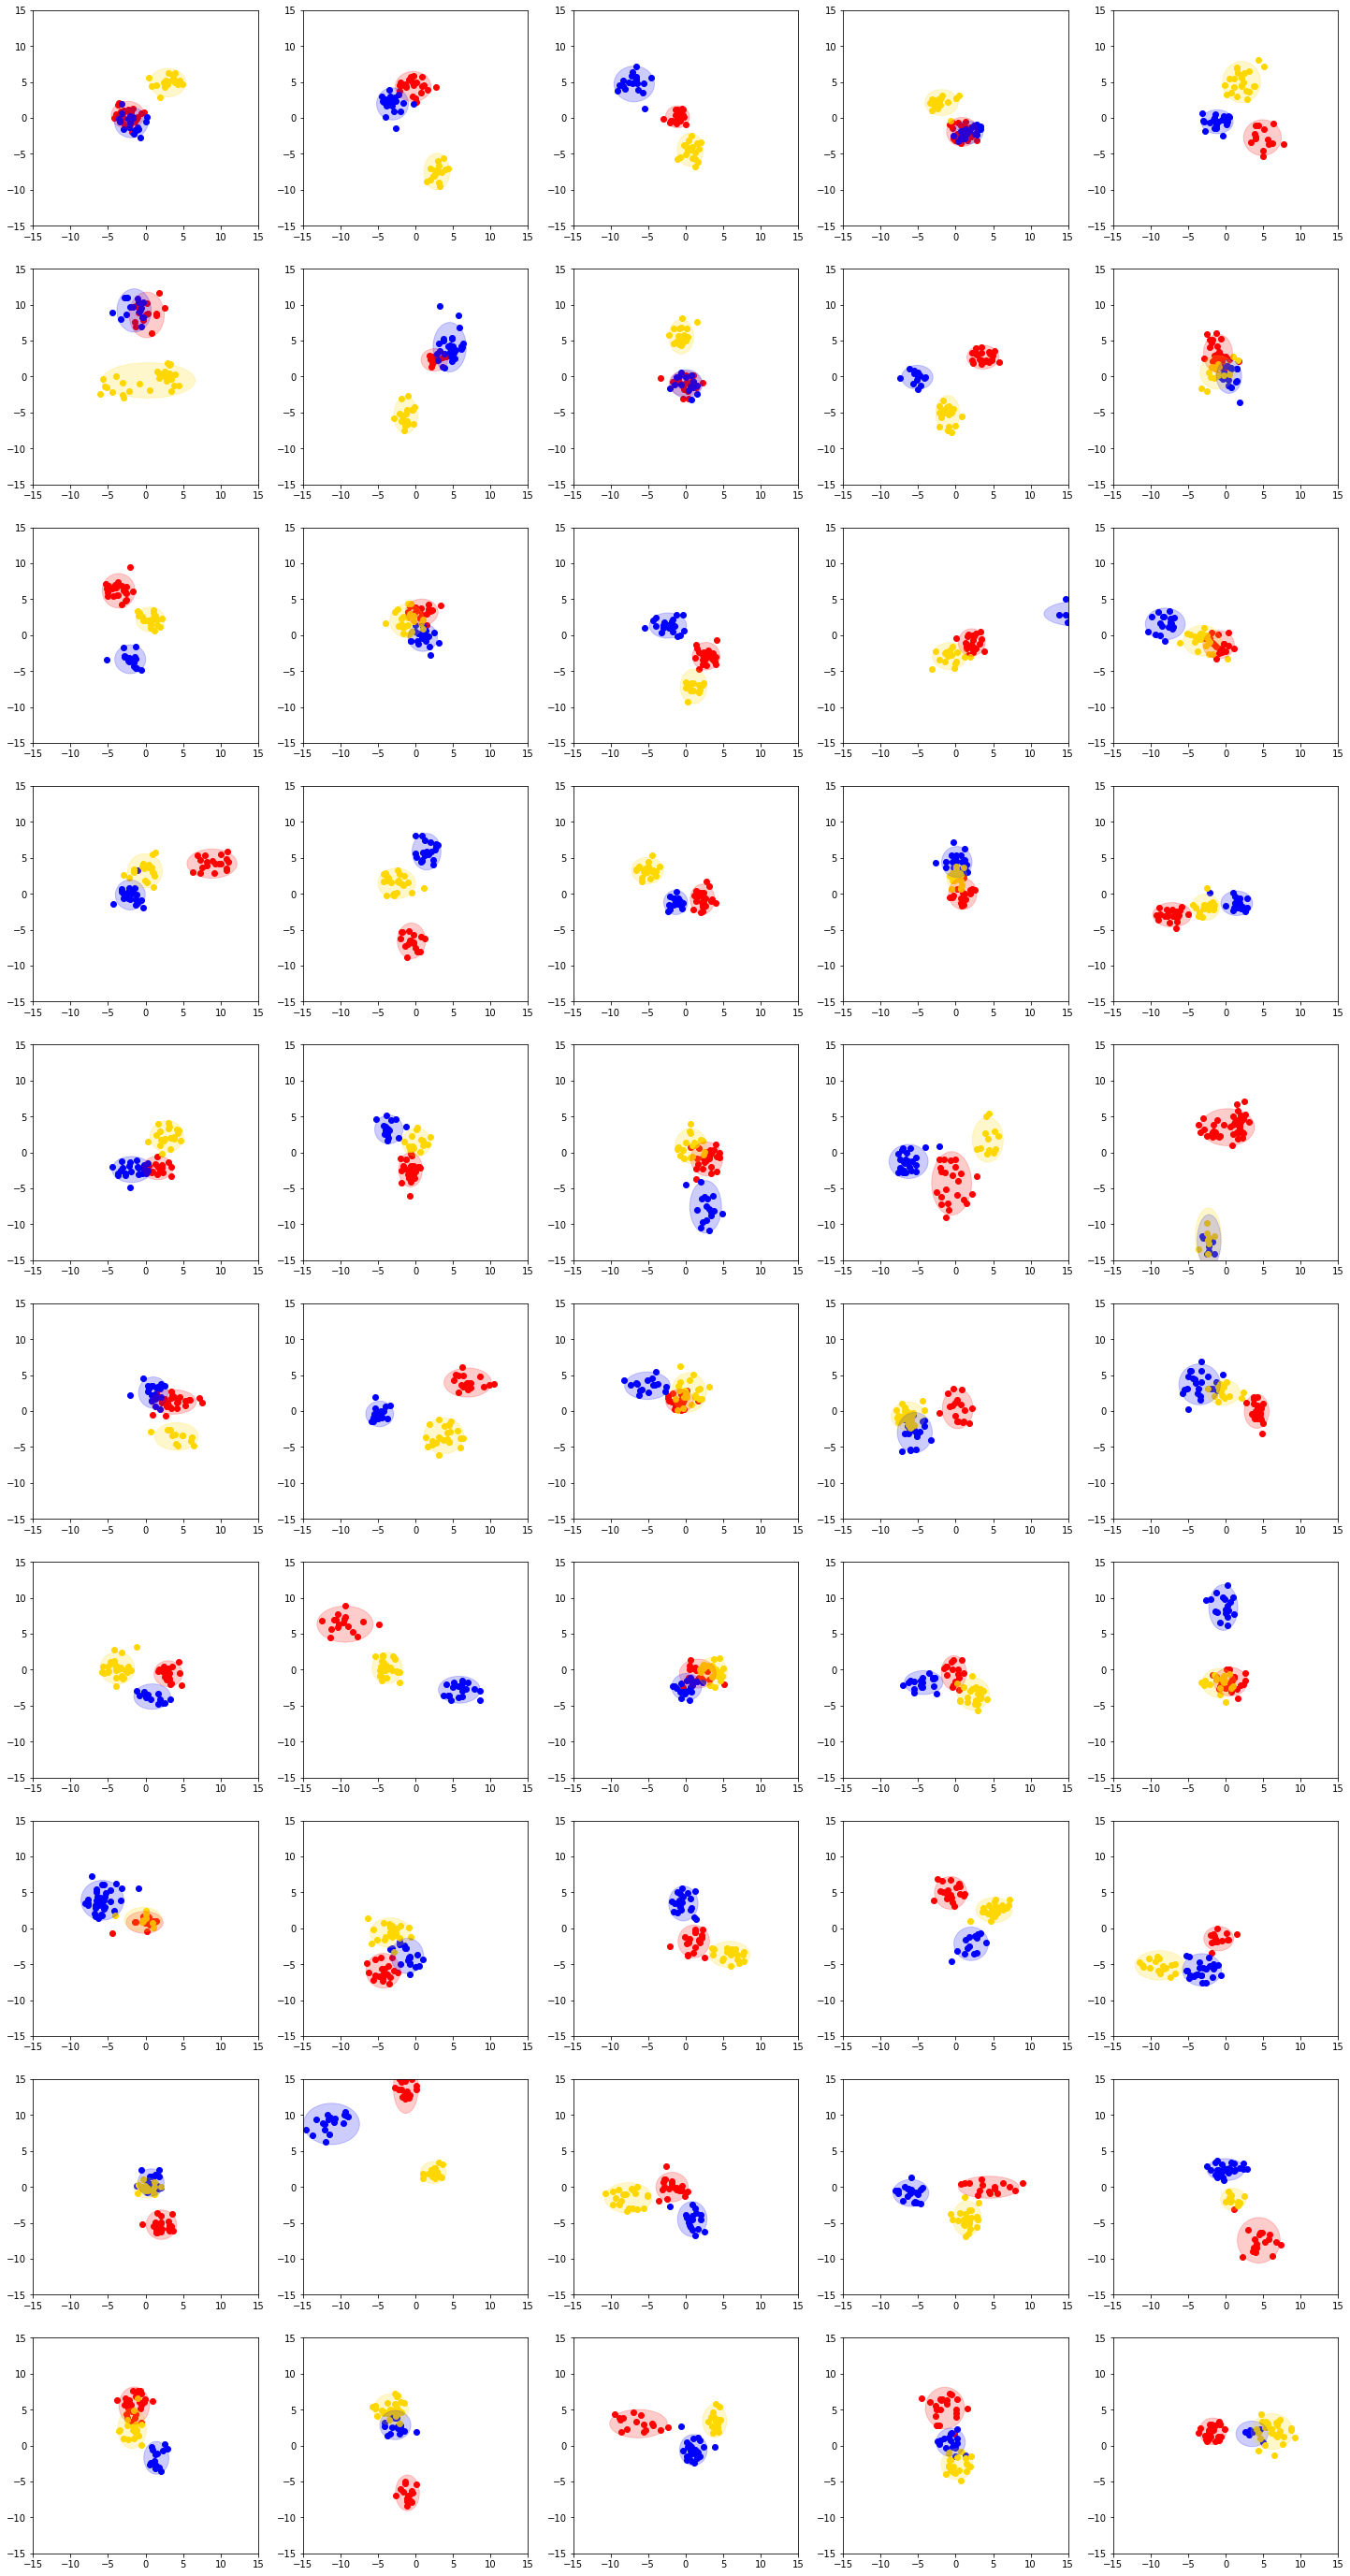

In [16]:
plot_samples(obs, states, q_eta, batch_size=50)